<a href="https://colab.research.google.com/github/vijaynadimpalli/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/NLP_Week4_Exercise_Shakespeare_Question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
!pip install tensorflow-gpu==2.0.0

     |████████████████████████████████| 380.8MB 44kB/s 
     |████████████████████████████████| 3.8MB 35.6MB/s 
     |████████████████████████████████| 450kB 37.6MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=61a1468dc73efcd2d30acc41654249f7a1e840745b0dbda321f5c58f73f35ec8
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorflow-estimator<2.4.0,>=2.3.0, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing ins

In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
# Figure out how to import regularizers
from tensorflow.keras import regularizers
###
import tensorflow.keras.utils as ku 
import numpy as np 

In [4]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2020-10-01 12:40:23--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2020-10-01 12:40:23 (111 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [5]:
print(max_sequence_len)
print(predictors.shape)
print(label.shape)

11
(15462, 10)
(15462, 3211)


In [14]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
word_index = tokenizer.word_index
embedding_dim = 100

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((total_words, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-10-01 13:23:00--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   211MB/s    in 1.6s    

2020-10-01 13:23:02 (211 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [17]:
model = Sequential()
model.add(Embedding(total_words,embedding_dim,input_length=max_sequence_len-1,trainable=False,weights=[embeddings_matrix])),
model.add(LSTM(64,activation='relu',return_sequences=True)),
model.add(Dropout(0.2)),
model.add(LSTM(64,activation='relu',return_sequences=False))
model.add(Dense(64,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0,l2=0.001)))
model.add(Dense(total_words,activation='softmax'))
# Pick an optimizer
opt = Adam()
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy']) # Pick a loss function and an optimizer)
print(model.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 10, 100)           321100    
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 64)            42240     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 3211)              208715    
Total params: 609,239
Trainable params: 288,139
Non-trainable params: 321,100
__________________________________________

In [18]:
history = model.fit(predictors, label, epochs=100, verbose=1)

Train on 15462 samples
Epoch 1/100
15462/15462 [==============================] - 17s 1ms/sample - loss: 6.9205 - accuracy: 0.0182
Epoch 2/100
15462/15462 [==============================] - 15s 954us/sample - loss: 6.5184 - accuracy: 0.0247
Epoch 3/100
15462/15462 [==============================] - 15s 941us/sample - loss: 6.4195 - accuracy: 0.0261
Epoch 4/100
15462/15462 [==============================] - 15s 969us/sample - loss: 6.3442 - accuracy: 0.0278
Epoch 5/100
15462/15462 [==============================] - 15s 945us/sample - loss: 6.2725 - accuracy: 0.0337
Epoch 6/100
15462/15462 [==============================] - 15s 942us/sample - loss: 6.1853 - accuracy: 0.0371
Epoch 7/100
15462/15462 [==============================] - 15s 941us/sample - loss: 6.0769 - accuracy: 0.0444
Epoch 8/100
15462/15462 [==============================] - 14s 937us/sample - loss: 5.9408 - accuracy: 0.0470
Epoch 9/100
15462/15462 [==============================] - 15s 951us/sample - loss: 5.8318 - accura

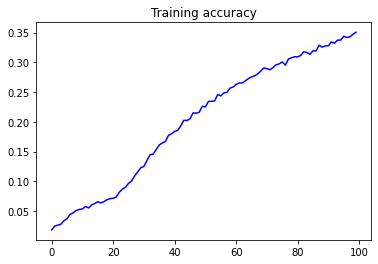

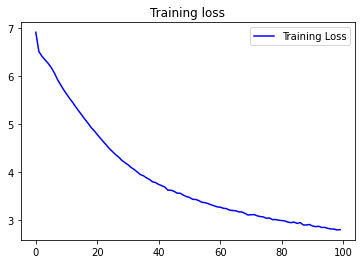

In [19]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [20]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope you say the skill shall erred thy good rhyme untrue ' you dwell me give thee still told told so denote pay true writ muse grow see tell stay you dearer told bright sort ' room of slain staineth burn burn thereby me room burn room thereby me new burn thereby burn staineth burn cross'd cross'd staineth matter room room me ' bright cross'd common meant hid burn cross'd burn room burn me of sense of white sun rage hid ' it decays express'd reap showers you are still are room me ' in rolling hid ' room ' burn
